### Train a particular convolutional neural network on CIFAR10 image data. Experiment with different number of parameters and plot corresponding training & validation error rates. Also experiment with variability by transforming the RGB color map of the input images HSV and adjusting saturation values and noticing changes in images. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh 

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [28]:
def dimensions(a):
    if not type(a) == list:
        return []
    print ([len(a)] + dim(a[0]))

In [4]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

In [5]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [ ]:
## tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [7]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

In [8]:
# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [9]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())

In [10]:
def cal_total_param():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        #print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)

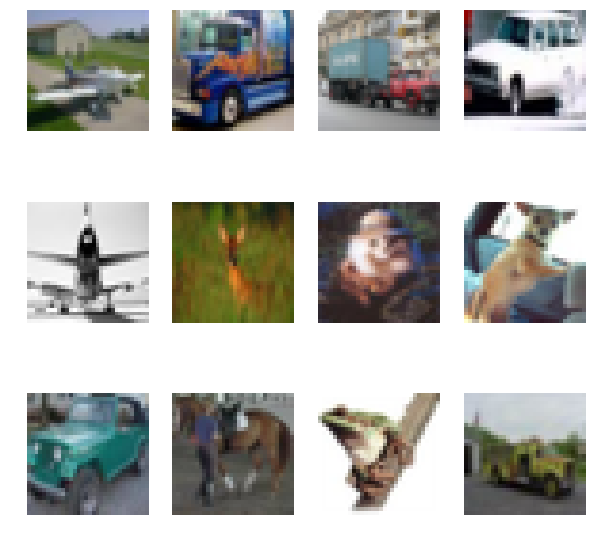

In [11]:
data_set="cifar"
train,val,test=get_data(data_set=data_set)
fig, axes = plt.subplots(3,4,figsize=(10,10))
for j in range(3):
    for k in range(4):
        i = np.random.choice(range(len(train[0])))
        axes[j][k].set_axis_off()
        axes[j][k].imshow(train[0][i].reshape(32,32,3))

In [34]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=32
nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error = []
val_error = []

with tf.Session() as sess:
        #train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

conv1/W:0 [5, 5, 3, 32] 0.047503244
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028849835
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.02143799
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.087070085
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.078197717666626
get stats time 0.31743931770324707
Epoch 0 Train loss, accuracy 1.871327446091175 0.32199999999999995
get stats time 0.14499711990356445
EPoch 0 Validation loss, accuracy 1.8956343017339705 0.31120000000000003
Batch 0.0
Batch 10.0
Epoch time 0.8654274940490723
Batch 0.0
Batch 10.0
Epoch time 0.8585615158081055
get stats time 0.28821849822998047
Epoch 2 Train loss, accuracy 1.4701673631429673 0.4706
get stats time 0.14297246932983398
EPoch 2 Validation loss, accuracy 1.5324800975561141 0.45
Batch 0.0
Batch 10.0
Epoch time 0.8559296131134033
Batch 0.0
Batch 10.0
Epoch time 0.857177734375
get stats time 0.2886519432067871
Epoch 4 Train loss, accuracy 1.3258807257890701 0.5264
get stats time 0.1429436206817627
EPoch 4 Validation loss, ac

In [35]:
cal_total_param()

1105098


<function matplotlib.pyplot.show(*args, **kw)>

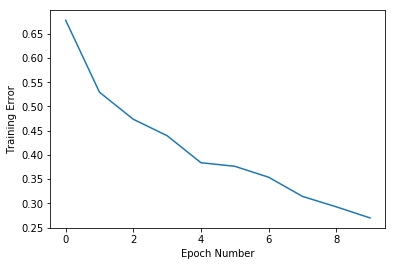

In [36]:
plt.plot(train_error)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

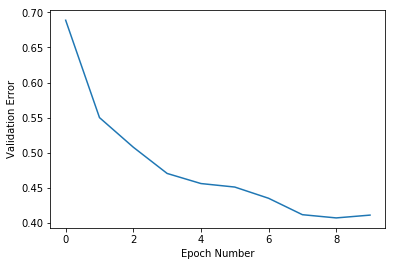

In [37]:
plt.plot(val_error)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

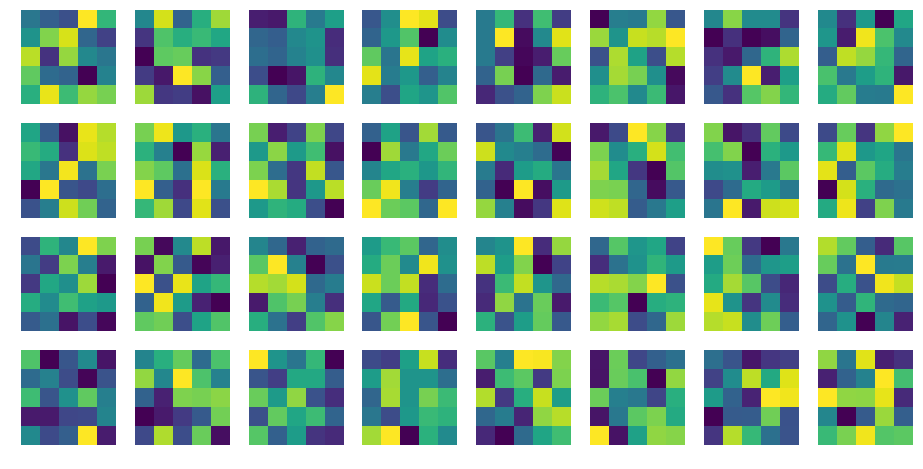

In [38]:
rows = 4
cols = 8
filters_reshape = filters.reshape(-1, 5, 5)
filters_reshape.shape
plt.figure(figsize=(cols*2, rows*2))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(filters_reshape[i])
    plt.axis('off')
plt.axis('off')
plt.show()

In [39]:
## tf.reset_default_graph()

def create_network_deep():
    pool_ksize=[1,4,4,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=16)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=32)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5,5],num_features=64)
#             pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')       
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(relu3,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [40]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=32
nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_changes = []
val_error_changes = []

with tf.Session() as sess:
        #train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_deep()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_changes.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_changes.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

conv1/W:0 [5, 5, 3, 16] 0.06417331
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 32] 0.04089171
conv2/b:0 [32] 0.0
conv3/W:0 [5, 5, 32, 64] 0.028900383
conv3/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021428108
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08784951
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.9467897415161133
get stats time 0.2737605571746826
Epoch 0 Train loss, accuracy 1.9504286595344542 0.2873
get stats time 0.12076663970947266
EPoch 0 Validation loss, accuracy 1.9669913021802903 0.2862
Batch 0.0
Batch 10.0
Epoch time 0.7150378227233887
Batch 0.0
Batch 10.0
Epoch time 0.7085199356079102
get stats time 0.23720026016235352
Epoch 2 Train loss, accuracy 1.5409071096181868 0.4361
get stats time 0.11878585815429688
EPoch 2 Validation loss, accuracy 1.5803902222633361 0.4164
Batch 0.0
Batch 10.0
Epoch time 0.7004947662353516
Batch 0.0
Batch 10.0
Epoch time 0.7016270160675049
get stats time 0.23714375495910645
Epoch 4 Train loss, accuracy 1.3954804553627969 0.4915
get stats time 0.11921477

In [41]:
cal_total_param()

1116714


<function matplotlib.pyplot.show(*args, **kw)>

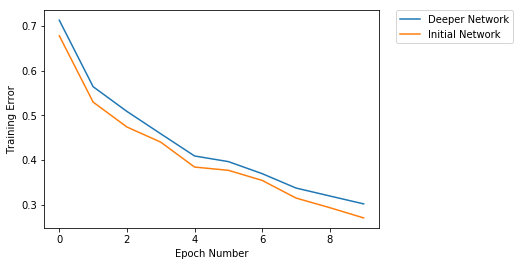

In [42]:
plt.plot(train_error_changes, label="Deeper Network")
plt.plot(train_error, label="Initial Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

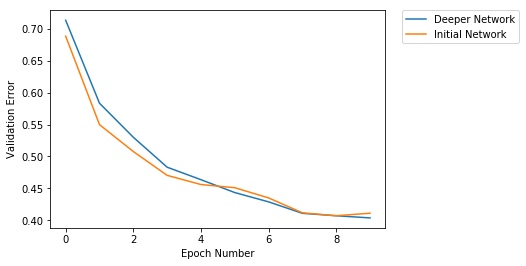

In [43]:
plt.plot(val_error_changes, label="Deeper Network")
plt.plot(val_error, label="Initial Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

In [45]:
from skimage.color import rgb2hsv, hsv2rgb
test_img = train[0]
img_rgb = np.reshape(test_img, (-1, 32, 32, 3))
for i in range(img_rgb.shape[0]):
    img_rgb[i,:,:,:] = rgb2hsv(img_rgb[i,:,:,:])

In [46]:
for i in range(img_rgb.shape[0]):
    img_rgb[i,:,:,:] = rgb2hsv(img_rgb[i,:,:,:])

In [47]:
#Multiplies Saturation levels by 1.2
for i in range(img_rgb.shape[0]):
    img_rgb[i,:,:,1] = img_rgb[i,:,:,1] * 1.2
    img_rgb[i,:,:,1] = np.minimum(img_rgb[i,:,:,1], 1)

In [48]:
#Convert back to rgb
for i in range(img_rgb.shape[0]):
    img_rgb[i,:,:,:] = hsv2rgb(img_rgb[i,:,:,:])

In [49]:
train = (img_rgb.reshape(45000, 3072), train[1])

#### Resulting Images

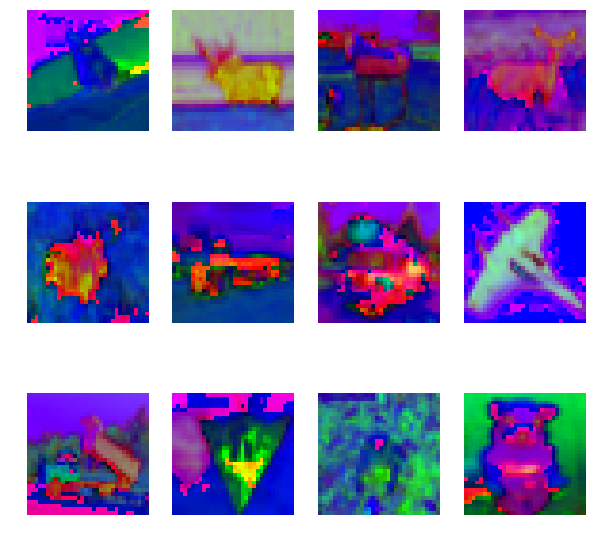

In [50]:
fig, axes = plt.subplots(3,4,figsize=(10,10))
for j in range(3):
    for k in range(4):
        i = np.random.choice(range(len(train[0])))
        axes[j][k].set_axis_off()
        axes[j][k].imshow(train[0][i].reshape(32, 32, 3))

In [52]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="cifar"
model_name="model"
keep_prob=.5
dim=32
nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_changes = []
val_error_changes = []

with tf.Session() as sess:
        #train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_deep()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_changes.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_changes.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

conv1/W:0 [5, 5, 3, 16] 0.06484792
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 32] 0.040740956
conv2/b:0 [32] 0.0
conv3/W:0 [5, 5, 32, 64] 0.028942028
conv3/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.021429395
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08577563
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.9552135467529297
get stats time 0.26650452613830566
Epoch 0 Train loss, accuracy 1.8897582077622412 0.31310000000000004
get stats time 0.11900734901428223
EPoch 0 Validation loss, accuracy 2.274117310929298 0.15440000000000004
Batch 0.0
Batch 10.0
Epoch time 0.7066543102264404
Batch 0.0
Batch 10.0
Epoch time 0.7073791027069092
get stats time 0.23510527610778809
Epoch 2 Train loss, accuracy 1.5775303180217741 0.4351
get stats time 0.11725258827209473
EPoch 2 Validation loss, accuracy 2.9798160179376607 0.1438
Batch 0.0
Batch 10.0
Epoch time 0.7002217769622803
Batch 0.0
Batch 10.0
Epoch time 0.7006533145904541
get stats time 0.23606038093566895
Epoch 4 Train loss, accuracy 1.455320269739628 0.4735

<function matplotlib.pyplot.show(*args, **kw)>

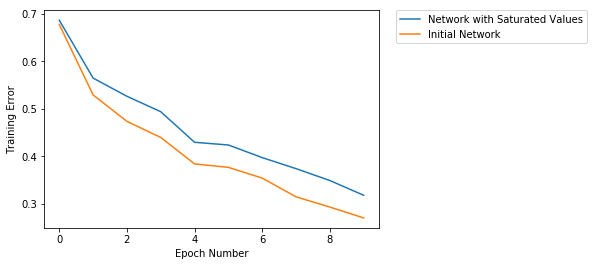

In [54]:
plt.plot(train_error_changes, label="Network with Saturated Values")
plt.plot(train_error, label="Initial Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

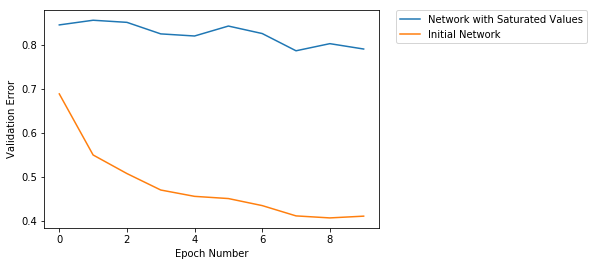

In [55]:
plt.plot(val_error_changes, label="Network with Saturated Values")
plt.plot(val_error, label="Initial Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show